In [1]:
import numpy as np   
import pandas as pd
import os

# Kaggledaki verisetine bağlanmak için dosya yolu verilmiş.
# Çalışma kaggle üzerinden olduğu için bunun yapılmasına gerek yok.(Hata verir.)
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import cv2
import re
from PIL import Image
from tqdm import tqdm

!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) başaryıla yüklendi."

import albumentations  as A
from albumentations.pytorch.transforms import ToTensor

from albumentations.pytorch import ToTensorV2

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
DIR_INPUT = "/content/drive/MyDrive/wheat"
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'
print(DIR_INPUT)
print(DIR_TRAIN)
print(DIR_TEST)

     |████████████████████████████████| 102 kB 3.7 MB/s 
     |████████████████████████████████| 47.6 MB 34 kB/s 
albumentations==1.1.0 başaryıla yüklendi.
/content/drive/MyDrive/wheat
/content/drive/MyDrive/wheat/train
/content/drive/MyDrive/wheat/test


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/wheat/train.csv')
print(train_df.info())
print(train_df.describe())
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB
None
          width    height
count  147793.0  147793.0
mean     1024.0    1024.0
std         0.0       0.0
min      1024.0    1024.0
25%      1024.0    1024.0
50%      1024.0    1024.0
75%      1024.0    1024.0
max      1024.0    1024.0


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [5]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0
...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0


In [6]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[:100]
train_ids = image_ids[100:]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape 

((2873, 8), (144920, 8))

In [7]:
class WheatDataset(Dataset):
    def __init__(self,df,image_dir,transforms=None):
        super().__init__
        self.image_ids = df['image_id'].unique()
        self.df=df
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self,index:int):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        boxes = records[['x', 'y', 'w', 'h']].values
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            chec = tuple(map(torch.tensor, zip(*sample['bboxes'])))
            if len(chec)!=0:     
                check = torch.stack(chec).permute(1, 0)
                for l in check:
                    if len(l)!=0: 
                        target['boxes'] = check
                        image = sample['image'] 
                        break
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [8]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
def get_train_transform():
    return A.Compose([
        # A.Normalize(mean, std, always_apply=True),        
        A.Flip(0.5),
        A.Blur(blur_limit=5, p=.4),
        A.ShiftScaleRotate(shift_limit=0.0625,scale_limit=0.1, rotate_limit=45,p=0.5),
        A.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=0.5),
#         A.HueSaturationValue(p=0.1), 
#         A.CLAHE(clip_limit = 2, tile_grid_size = (16,16), p=0.2), 
#         A.RandomGamma(p=0.2),
        ToTensorV2(p=1.0), 
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
#         A.Normalize(mean, std, always_apply=True),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2 
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [10]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    collate_fn=collate_fn
)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=8,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[273.0000, 481.0000, 340.5000, 512.0000],
        [366.5000, 496.0000, 417.0000, 512.0000],
        [ 63.5000, 444.0000, 113.5000, 504.5000],
        [ 42.5000, 407.0000,  88.0000, 456.5000],
        [  0.0000, 383.5000,  48.0000, 456.0000],
        [267.5000, 389.0000, 322.5000, 455.0000],
        [282.5000, 339.5000, 308.5000, 371.5000],
        [336.5000, 291.5000, 375.0000, 324.0000],
        [378.5000, 370.5000, 430.5000, 434.0000],
        [481.0000, 379.5000, 512.0000, 423.0000],
        [461.0000, 309.0000, 503.0000, 334.5000],
        [440.0000, 252.5000, 478.5000, 292.0000],
        [322.0000, 225.5000, 370.5000, 260.5000],
        [403.5000, 174.5000, 453.0000, 219.0000],
        [358.5000, 124.5000, 425.0000, 176.5000],
        [439.0000,  42.5000, 488.5000, 112.0000],
        [410.0000,  18.0000, 445.0000,  73.5000],
        [315.5000,  60.5000, 376.0000, 135.0000],
        [228.0000,  67.0000, 260.5000,  94.5000],
        [196.0000, 110.5000, 217.5000, 1

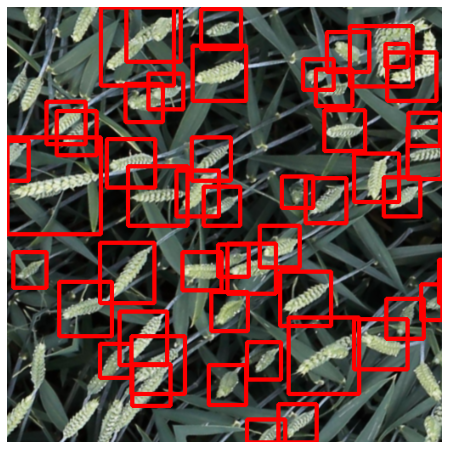

In [14]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
print(targets[0])
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
print(sample.mean())
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

In [15]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# lr_scheduler = None
num_epochs = 100

In [ ]:
loss_hist = Averager()
itr = 1
for epoch in range(num_epochs):
    loss_hist.reset()
    tk0=tqdm(train_data_loader,total=int(len(train_dataset)/train_data_loader.batch_size))
    for images, targets, image_ids in tk0:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        optimizer.zero_grad()
        #losses.backward()
        optimizer.step()
        tk0.set_postfix_str(f"EPOCH : {epoch+1} train_loss : {loss_hist.value}")
        itr += 1
    
    if lr_scheduler is not None:
        lr_scheduler.step(loss_hist.value)
    
    with torch.no_grad():
        loss_hist.reset()
        tk0=tqdm(valid_data_loader,total=int(len(valid_dataset)/valid_data_loader.batch_size))
        for images, targets, image_ids in tk0:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            tk0.set_postfix_str(f"EPOCH : {epoch+1} valid_loss : {loss_hist.value}")
            itr += 1

  0%|          | 0/204 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 1/204 [00:21<1:12:41, 21.49s/it, EPOCH : 1 train_loss : 4.906627020369664]

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')